In [218]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
import numpy as np
import scipy
import scipy.linalg

import matplotlib.patches
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.linalg import sqrtm
from matplotlib.patches import Ellipse


%matplotlib inline

In [220]:
def plot_3d_function(f, a = 10, k = 100):
    x = np.linspace(-a, a, k)
    y = x.copy()
    xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    z = f(xy)
    fig = go.Figure(data=[go.Surface(x = x,  y= y, z=z.reshape((x.shape[0], -1)))])
    fig.update_layout(title = f.__name__, margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

# Funkcje celu

In [221]:
def sphere_function(X):
    return np.sum(X**2, axis=1)

In [6]:
def ellipsoid_function(X, a=2):
    n = X.shape[-1]
    return np.sum((a**(np.arange(n)/(n-1)))*X**2, axis=1)

In [8]:
def rastrigin_function(X):
    return 10.0 * X.shape[1] + np.sum(X**2, axis=1) - 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [24]:
def schwefel_function(X):
    return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

def objective_function_F7(X):
    res = []
    for x in X:
        if any([False if v >= -500 and v <= 500 else True for v in x]):
            res.append(100000)
        else:
            res.append(418.9829 * X.shape[1] + np.sum(x * np.sin(np.sqrt(np.abs(x)))))
    return np.array(res)
    #return 418.9829 * X.shape[1] - np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [12]:
def griewank_function(X):
    return 1 + np.sum(X**2 / 4000, axis=1) - np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

In [14]:
def cigar_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = X[:,0]**2
    x2 = np.sum(a*X[:,1:]**2, axis = 1)
    return x1+x2

In [16]:
def discus_function(X, a = 3):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum(X[:,1:]**2, axis = 1)
    return x1+x2

In [18]:
def cigar_discus_function(X, a = 2):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    x1 = a*X[:,0]**2
    x2 = np.sum((a**0.5)*X[:,1:-1]**2, axis = 1)
    x3 = X[:,-1]**2
    return x1+x2+x3

In [103]:
def parab_ridge_function(X):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    b = np.any((X > 10.0) | (X < -10), axis=1) * 100000
    x1 = - X[:,0]
    c = np.any((X[:, 0] > 10.0) | (X[:, 0] < -10)) * 100000
    x2 = 100*np.sum(X[:,1:]**2, axis = 1)
    return (x1+c)+x2+b

In [22]:
def two_axes_function(X, a = 5):
    if len(X.shape) == 1:
        X = X[np.newaxis,:]
    n = X.shape[-1]
    k = n//2
    x1 = np.sum(a*X[:,:k]**2, axis = 1)
    x2 = np.sum(X[:,k:]**2, axis = 1)
    return x1+x2

# Implementacja CMA-ES

In [84]:
class CMA_ES:
    def __init__(self, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        if weights:
            self.weights = weights
        else:
            self.weights = np.array([np.log(self.lam / 2 + 0.5) - np.log(i + 1) if i < self.mu else 0
                        for i in range(self.lam)])
            self.weights /= np.sum(self.weights)
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs
        self.count = 0
        self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps = np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = []   
        self.best = (x0, np.inf)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.identity(N)
        self.last_pop_sorted = None
        
    def _update_eigensystem(self):
        if self.counteval <= self.updated_eval + self.lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj próbkę nowych osobników"""
        return np.random.multivariate_normal(self.xmean, self.C * (self.sigma ** 2), size=self.lam)
    
    def update(self, x, fitvals):
        """Zaktualizuj wartości uzyskanych parametrów"""
        self.counteval += fitvals.shape[0] # Zwiększamy licznik wykonań
        N = self.xmean.shape[0]
        self.count += 1
        x_old = self.xmean.copy()
        
        # Posortuj osobniki po wartości funkcji celu
        self.fitvals = fitvals
        I = np.argsort(self.fitvals)
        x = x[I, :]
        self.last_pop_sorted = x
        if self.fitvals[0] < 100000:
            self.best = (x[0], self.fitvals[0])
        
        self.xmean = (self.weights @ x).ravel()
        y = (x - self.xmean) / self.sigma
        # Aktualizacja ścieżki ewolucji dla sigmy
        inv_sqr = np.linalg.inv(sqrtm(self.C))
        self.ps = (1. - self.cs) * self.ps + np.sqrt(self.cs * (2. - self.cs) * self.mueff) * np.dot(self.inv_sqrt, ((self.xmean - x_old) / self.sigma))        
        # Aktualizacja ścieżki ewolucji dla macierzy kowariancji
        self.pc = (1. - self.cc) * self.pc + np.sqrt(self.cc * (2. - self.cc) * self.mueff) * ((self.xmean - x_old) / self.sigma)
        
        #Aktualizacja macierzy kowariancji
        self.C = (1. - self.c1 - self.cmu * np.sum(self.weights)) * self.C
        
        self.C += self.c1 * self.pc[:, np.newaxis] @ self.pc[:, np.newaxis].T
        self.C += self.cmu * np.dot(y.T, np.diag(self.weights)).dot(y)
        self.C = (self.C + self.C.T)/2. # Upewniamy się, że macierz jest symetryczna
        
        # Aktualizacja rozmiaru kroku
        self.sigma = self.sigma * np.exp((self.cs / self.damps) * (np.linalg.norm(self.ps) / self.chiN - 1.))
        

    def terminate(self):
        """Zakończ algorytm"""
        if self.counteval <= 0:
            return False
        if self.count >= self.maxfevals:
            print('Max iteration reached')
            return True
        if self.best[1] <= 1e-2:
            print('Best reached treshold')
            return True
        if self.condition_number > 1e13:
            print('Condition number reached')
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            print('Eigen values sigma reached')
            return True
        return False

In [27]:
def optimize(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
    cma_es = CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    rest_of = []
    mean = []
    cs = []
    cntr = 0
    while not cma_es.terminate():
        cma_es._update_eigensystem()
        cntr+=1
        #cs.append(cma_es.C * cma_es.sigma ** 2)
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        #rest_of.append(cma_es.last_pop_sorted)
        #mean.append(cma_es.xmean)
        if cntr % 10 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res, rest_of, cs, mean

In [28]:
def optimize_and_plot(f, sigma = 1, d = 10, popsize = None, maxfevals=1000):
    x0 = np.repeat(100.0, d)
    res, rest, cs, mean = optimize(f, x0, sigma, popsize = popsize, maxfevals=maxfevals)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    fig.show()
    return [x[0] for x in res], rest, cs, mean

In [29]:
def ellipse(center, width, height, a=0, color="r"):
    return Ellipse(center, width, height, angle=a, color=color, alpha=0.2)

def plot_cma(n, count, sigma, bests, worsts, mean, fun, dom_X=400, dom_Y=400):
    fig, axs = plt.subplots(count-1, 1, figsize=(9,9*count-1))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    domain_X = np.arange(-dom_X / 2, dom_X / 2, 0.25)
    domain_Y = np.arange(-dom_Y / 2, dom_Y / 2, 0.25)
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - fun(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    
    for i in range(n, n + count - 1):
        j = abs(n - i)
        z = 'r'
        g = 'g'
        lam = int(len(rest[i])/2)
        axs[j].contour(X, Y, Z, 50)
        axs[j].plot(rest[i][:, 0][0:lam], rest[i][:,  1][0:lam], 'o', color=z)
        axs[j].plot(rest[i][lam:, 0], rest[i][lam:, 1], 'o', color=z, alpha=0.2)
        axs[j].plot(best[i][0], best[i][1], 'o', markersize=12, color=z)
        
        axs[j].plot(rest[i+1][0:lam, 0], rest[i+1][0:lam, 1], 'o', color=g)
        axs[j].plot(rest[i+1][lam:, 0], rest[i+1][lam:, 1], 'o', color=g, alpha=0.2)
        axs[j].plot(best[i+1][0], best[i+1][1], 'o', markersize=12, color=g)

        eva, eve = np.linalg.eig(sigma[i])
        ew = 2 * np.sqrt(5.991 * np.min(eva))
        eh = 2 * np.sqrt(5.991 * np.max(eva))
        max_eve = eve[np.argmax(eva)]
        angle = np.arctan(max_eve[0] / max_eve[1]) * (180 / np.pi)
        el = ellipse(mean[i], ew, eh, angle, color=z)
        axs[j].add_artist(el)
        
        eva, eve = np.linalg.eig(sigma[i+1])
        ew = 2 * np.sqrt(5.991 * np.min(eva))
        eh = 2 * np.sqrt(5.991 * np.max(eva))
        max_eve = eve[np.argmax(eva)]
        angle = np.arctan(max_eve[0] / max_eve[1]) * (180 / np.pi)
        el = ellipse(mean[i+1], ew, eh, angle, color=g)
        axs[j].add_artist(el)
        
    plt.show()

# Ewaluacja CMA-ES

In [ ]:
best, rest, cs, mean = optimize_and_plot(sphere_function, d = 2)

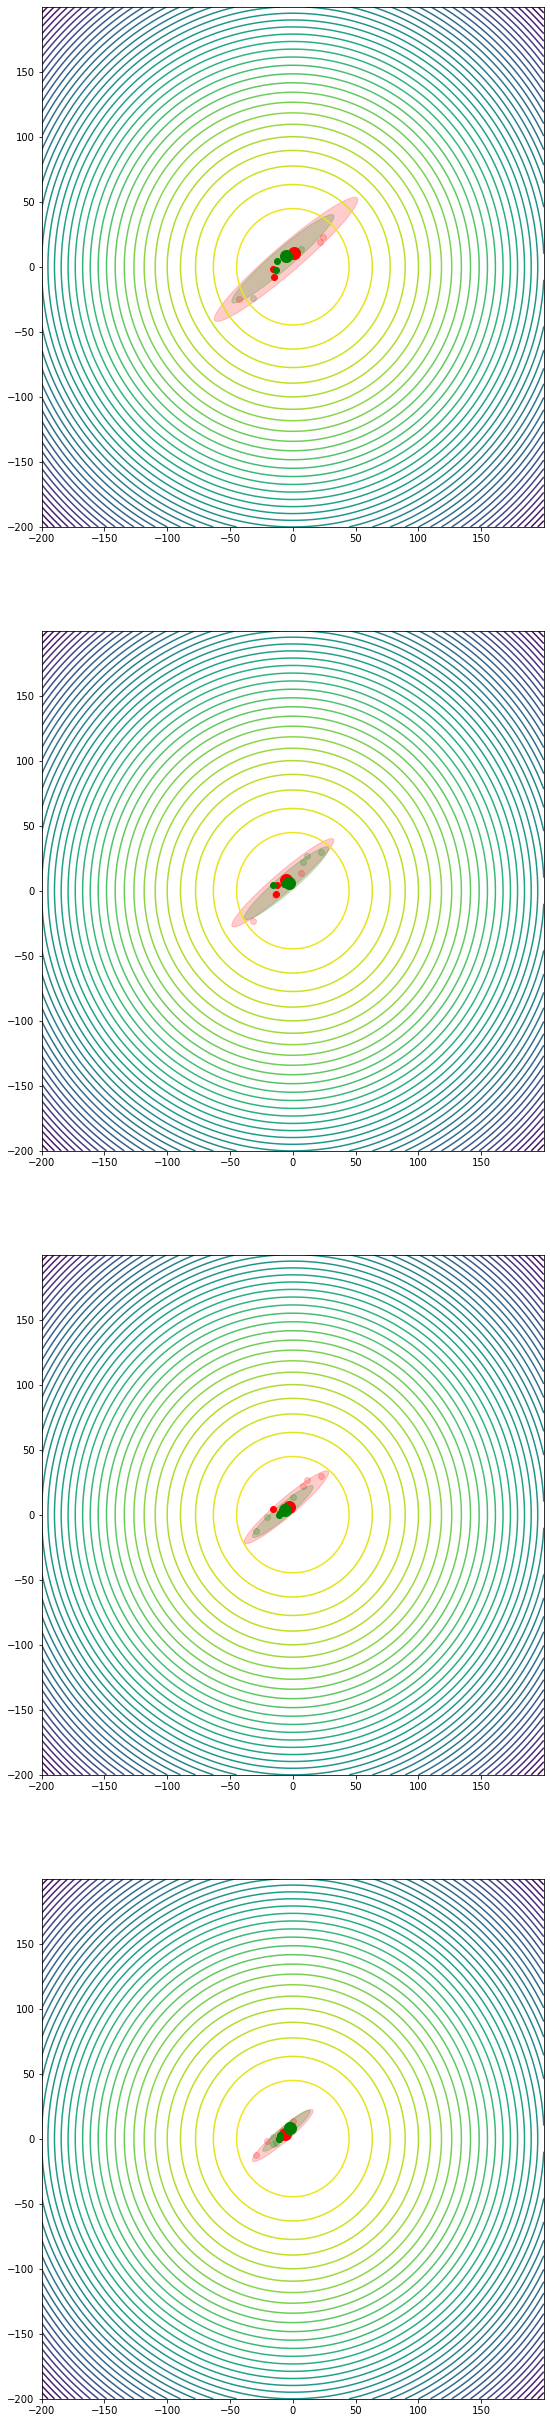

In [194]:
plot_cma(14, 5, cs, best, rest, mean, sphere_function)

In [ ]:
best, rest, cs, mean = optimize_and_plot(cigar_function, d=2)

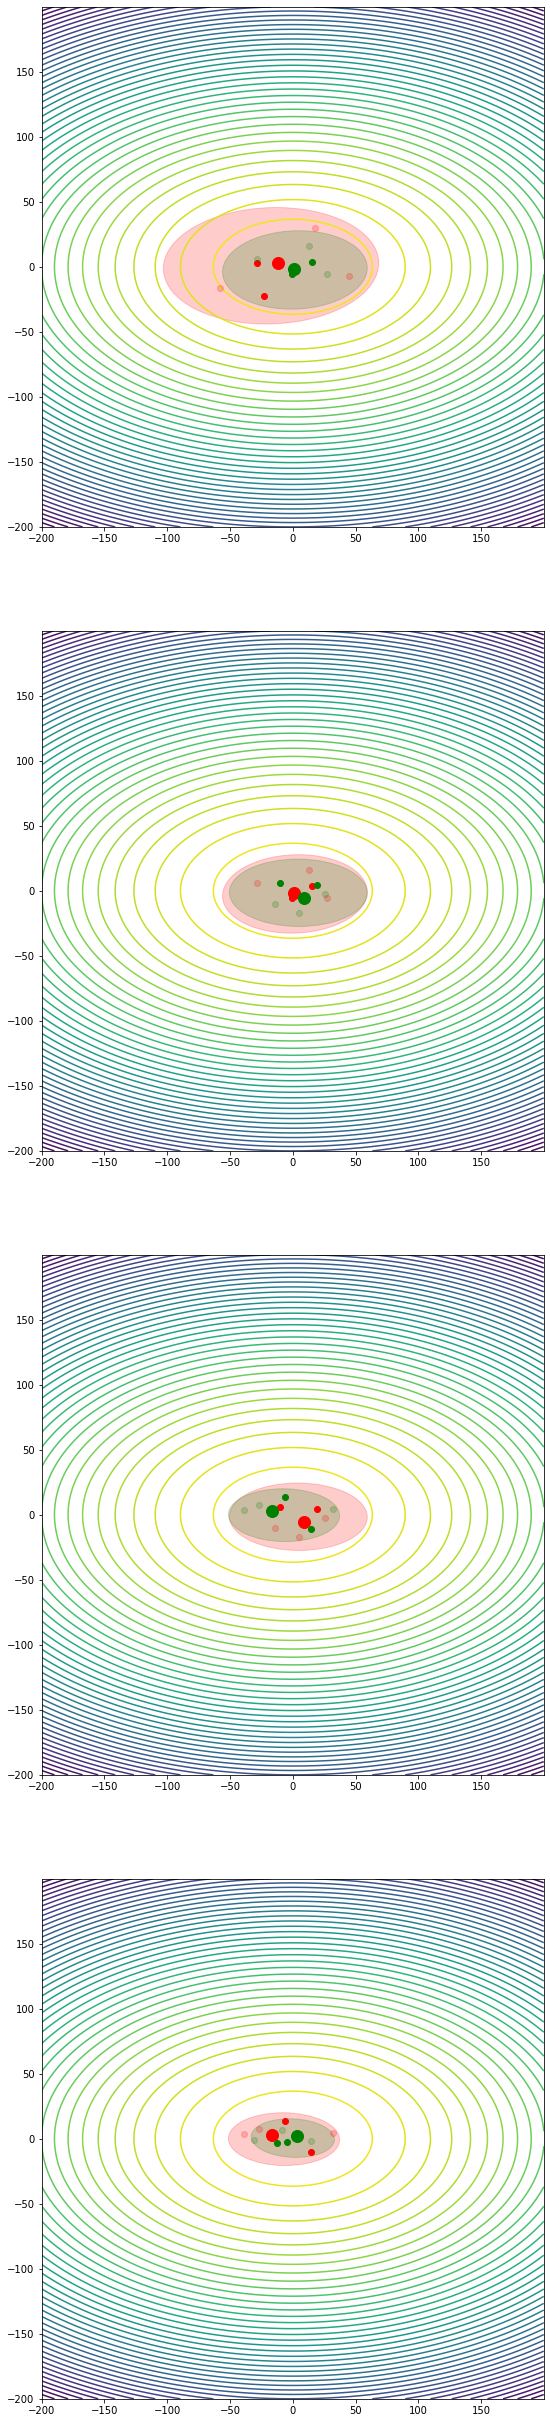

In [199]:
plot_cma(34, 5, cs, best, rest, mean, cigar_function)

In [ ]:
best, rest, cs, mean = optimize_and_plot(ellipsoid_function, d=2)

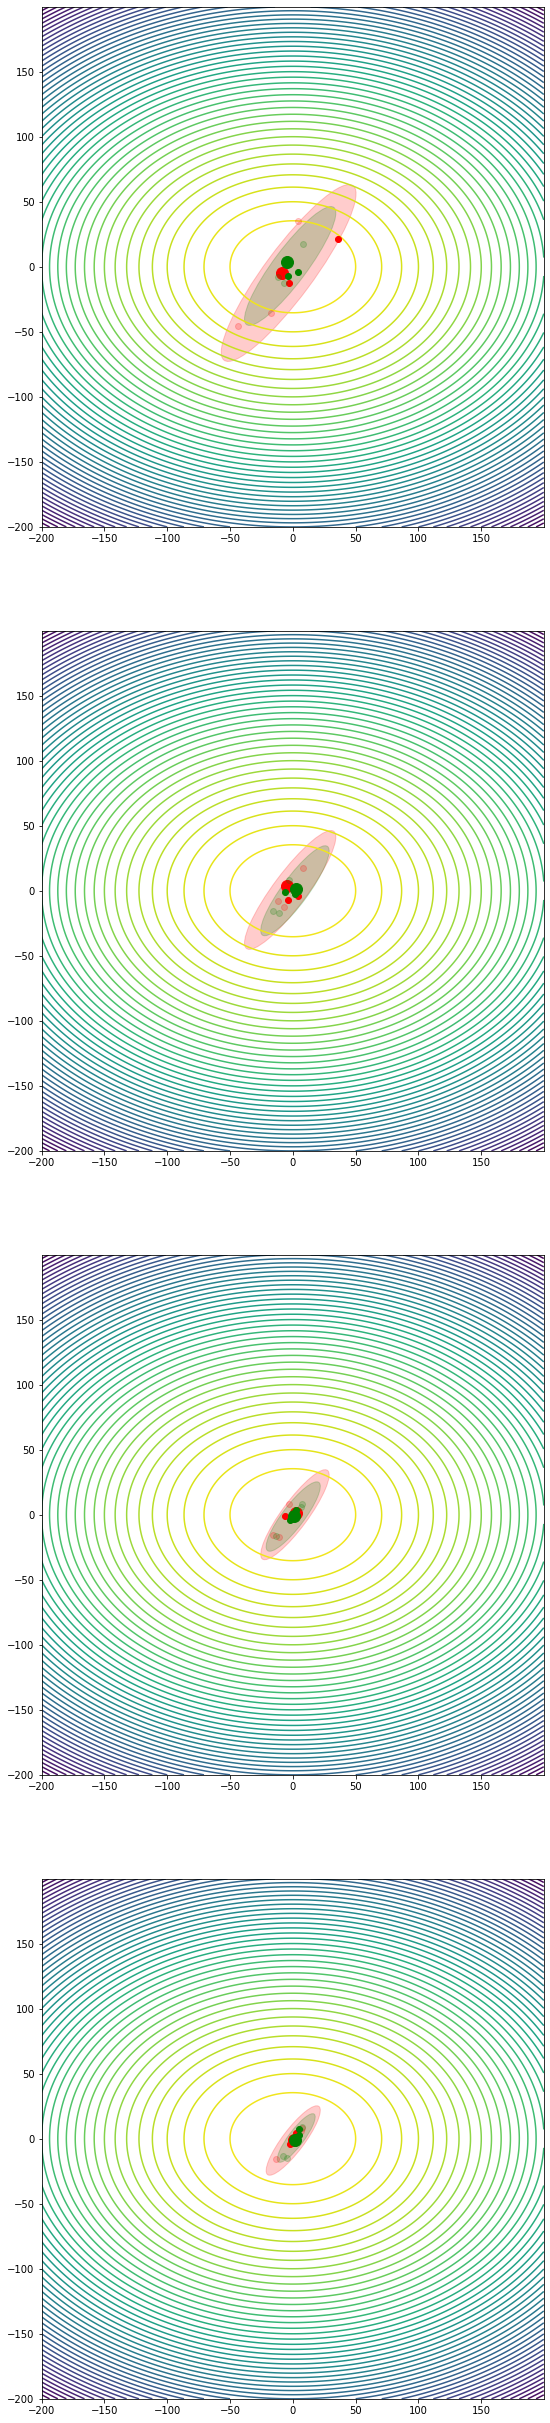

In [201]:
plot_cma(22, 5, cs, best, rest, mean, ellipsoid_function)

In [ ]:
best, rest, cs, mean = optimize_and_plot(rastrigin_function, d=2)

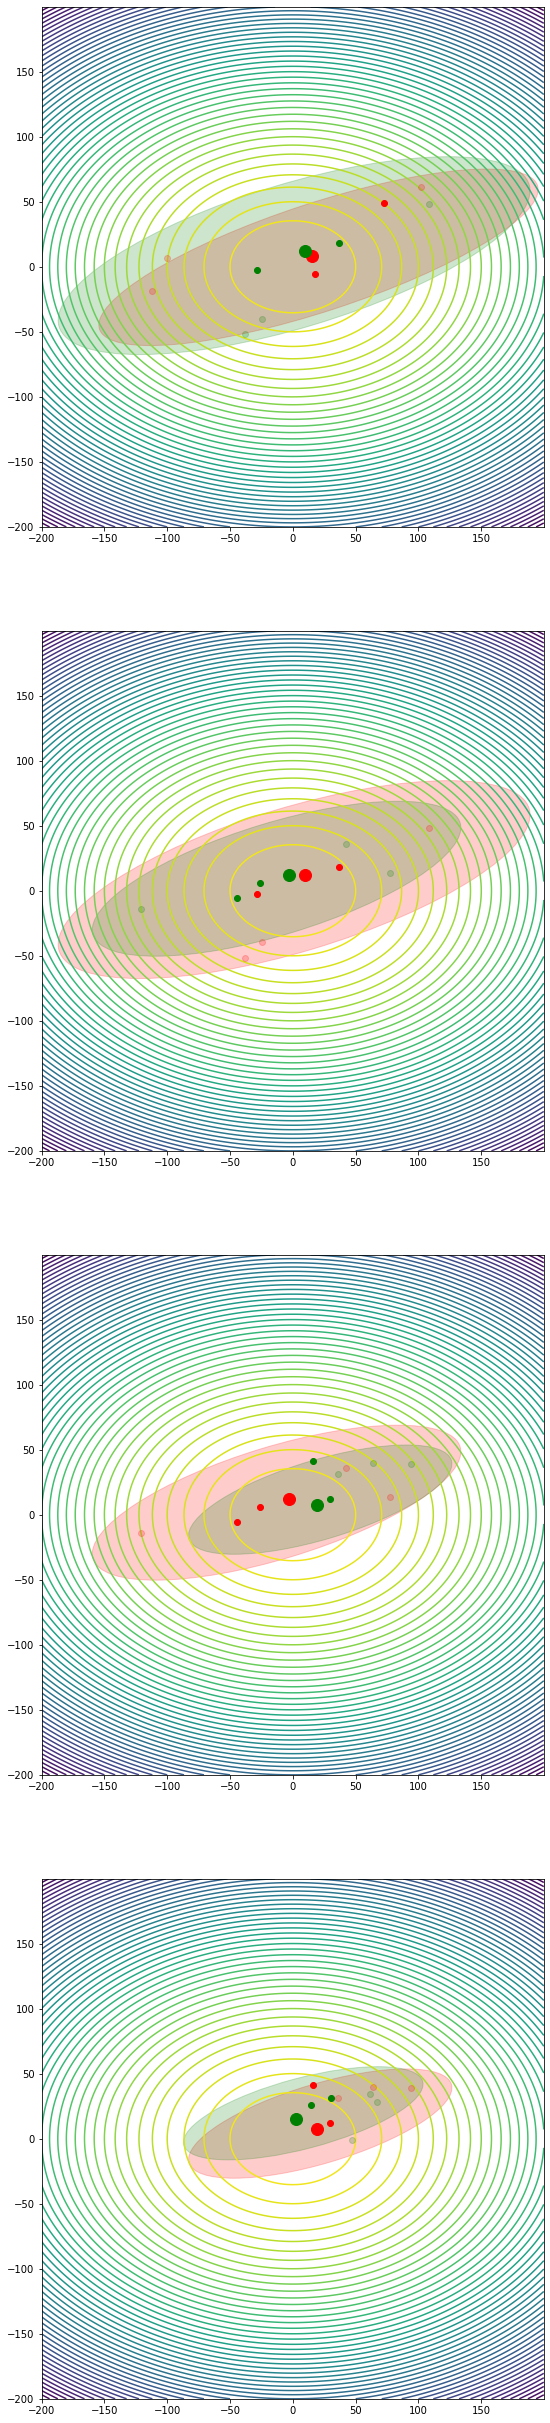

In [207]:
plot_cma(19, 5, cs, best, rest, mean, ellipsoid_function)

## zad2

##### Sphere function

In [ ]:
best, rest, cs, mean = optimize_and_plot(sphere_function, d = 5)

In [ ]:
best, rest, cs, mean = optimize_and_plot(sphere_function, d = 10, sigma=50)

In [ ]:
best, rest, cs, mean = optimize_and_plot(sphere_function, d = 20, sigma=100)

In [ ]:
best, rest, cs, mean = optimize_and_plot(sphere_function, d = 50, sigma=300)

#### Ellipsoid function

In [ ]:
best, rest, cs, mean = optimize_and_plot(ellipsoid_function, d = 5)

In [ ]:
best, rest, cs, mean = optimize_and_plot(ellipsoid_function, d = 10, sigma=50)

In [ ]:
best, rest, cs, mean = optimize_and_plot(ellipsoid_function, d = 20, sigma=10)

In [ ]:
best, rest, cs, mean = optimize_and_plot(ellipsoid_function, d = 50, sigma=10)

#### Rastrigin function

In [ ]:
best, rest, cs, mean = optimize_and_plot(rastrigin_function, d = 5, popsize=100, sigma=5)

In [ ]:
best, rest, cs, mean = optimize_and_plot(rastrigin_function, d = 10, popsize=400, sigma=100, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(rastrigin_function, d = 20, popsize=600, sigma=100, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(rastrigin_function, d = 50, popsize=1000, sigma=100, )

#### Schwefel function

In [ ]:
best, rest, cs, mean = optimize_and_plot(objective_function_F7, d = 5, popsize=500, sigma=1, maxfevals=3000)

In [ ]:
best, rest, cs, mean = optimize_and_plot(objective_function_F7, d = 10, popsize=800, sigma=25, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(objective_function_F7, d = 20, popsize=1000, sigma=0.1, maxfevals=2000)

In [ ]:
best, rest, cs, mean = optimize_and_plot(objective_function_F7, d = 50, popsize=5000, sigma=500, maxfevals=3000)

#### Griewank function

In [ ]:
best, rest, cs, mean = optimize_and_plot(griewank_function, d = 5, popsize=100, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(griewank_function, d = 10, popsize=100, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(griewank_function, d = 20, popsize=100, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(griewank_function, d = 50, popsize=100, sigma=20, )

#### Cigar function

In [ ]:
best, rest, cs, mean = optimize_and_plot(cigar_function, d = 5, popsize=10, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(cigar_function, d = 10, popsize=10, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(cigar_function, d = 20, popsize=10, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(cigar_function, d = 50, popsize=20, sigma=20, )

#### Discus function

In [ ]:
best, rest, cs, mean = optimize_and_plot(discus_function, d = 5, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(discus_function, d = 10, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(discus_function, d = 20, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(discus_function, d = 50, popsize=20, sigma=20, )

#### Parab ridge function

In [ ]:
best, rest, cs, mean = optimize_and_plot(parab_ridge_function, d = 5, popsize=20, sigma=20, )

#### Two axes function

In [ ]:
best, rest, cs, mean = optimize_and_plot(two_axes_function, d = 5, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(two_axes_function, d = 10, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(two_axes_function, d = 20, popsize=20, sigma=20, )

In [ ]:
best, rest, cs, mean = optimize_and_plot(two_axes_function, d = 50, popsize=20, sigma=20, )

#### zad3

In [232]:
class Active_CMA_ES:
    def __init__(self, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
        N = x0.shape[0]
        self.dimension = N
        self.chiN = N**0.5 * (1 - 1. / (4 * N) + 1. / (21 * N**2))
        self.lam = 4 + int(3 * np.log(N)) if not popsize else popsize
        print(f"Popsize: {self.lam}")
        self.mu = int(self.lam / 2)
        
        self.weights = np.hstack([np.ones(self.mu) / self.mu, -np.ones(self.lam - self.mu) / (self.lam - self.mu)])
        self.mueff = np.sum(self.weights)**2 / np.sum(self.weights**2)
        
        self.cc = (4 + self.mueff/N) / (N+4 + 2 * self.mueff/N)
        self.cs = (self.mueff + 2) / (N + self.mueff + 5)
        self.c1 = 2 / ((N + 1.3)**2 + self.mueff) 
        self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1/self.mueff) / ((N + 2)**2 + self.mueff)])
        self.damps = 2 * self.mueff/self.lam + 0.3 + self.cs
        self.count = 0
        self.xmean = x0[:]
        self.sigma = sigma
        self.pc = np.zeros(N) 
        self.ps = np.zeros(N) 
        self.lazy_gap_evals = 0.5 * N * self.lam * (self.c1 + self.cmu)**-1 / N**2
        self.maxfevals = maxfevals
        self.C = np.identity(N)
        self.counteval = 0 
        self.fitvals = []   
        self.best = (x0, np.inf)
        self.condition_number = 1
        self.eigen_values = np.ones(N)
        self.eigen_vectors = np.identity(N)
        self.updated_eval = 0
        self.inv_sqrt = np.identity(N)
        self.last_pop_sorted = None
        self.ccov = 2. / (N + np.sqrt(2.))**2
        self.beta = (4. * self.mu - 2.) / ((N + 12.)**2 + 4 * self.mu)
        
    def _update_eigensystem(self):
        if self.counteval <= self.updated_eval + self.lazy_gap_evals:
            return self
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.C)
        self.inv_sqrt = self.eigen_vectors @ np.diag(self.eigen_values**-0.5) @ self.eigen_vectors.T
        self.condition_number = self.eigen_values.max() / self.eigen_values.min()
         
    def sample(self):
        """Wylosuj próbkę nowych osobników"""
        return np.random.multivariate_normal(self.xmean, self.C * (self.sigma ** 2), size=self.lam)
    
    def update(self, x, fitvals):
        """Zaktualizuj wartości uzyskanych parametrów"""
        self.counteval += fitvals.shape[0] # Zwiększamy licznik wykonań
        N = self.xmean.shape[0]
        self.count += 1
        x_old = self.xmean.copy()
        
        # Posortuj osobniki po wartości funkcji celu
        self.fitvals = fitvals
        I = np.argsort(self.fitvals)
        x = x[I, :]
        self.last_pop_sorted = x
        if self.fitvals[0] < 100000:
            self.best = (x[0], self.fitvals[0])
        self.xmean = (self.weights @ x).ravel()
        y = (x - self.xmean) / self.sigma
        z = np.dot(self.inv_sqrt, y.T)
        self.ps = (1. - self.cs) * self.ps + np.sqrt(self.cs * (2. - self.cs) * self.mueff) * np.dot(self.inv_sqrt, ((self.xmean - x_old) / self.sigma))        
        # Aktualizacja ścieżki ewolucji dla macierzy kowariancji
        self.pc = (1. - self.cc) * self.pc + np.sqrt(self.cc * (2. - self.cc) * self.mueff) * ((self.xmean - x_old) / self.sigma)

        B = self.eigen_vectors
        D = np.diag(np.array(self.eigen_values ** 0.5))
        #print(z[:, :self.mu].shape)
        g = (1. / self.mu * z[:, :self.mu] @ z[:, :self.mu].T * (-1./self.mu * z[:, self.mu:] @ z[:, self.mu:].T))
        print(g)
        Z = (B @ D) @ g @ (B @ D).T
        self.C = (1 - self.cc) * self.C
        self.C += self.ccov * self.pc[:, np.newaxis] @ self.pc[:, np.newaxis].T
        self.C += self.beta * Z
        self.C = (self.C + self.C.T)/2. # Upewniamy się, że macierz jest symetryczna
        
        # Aktualizacja rozmiaru kroku
        self.sigma = self.sigma * np.exp((self.cs / self.damps) * (np.linalg.norm(self.ps) / self.chiN - 1.))
        

    def terminate(self):
        """Zakończ algorytm"""
        if self.counteval <= 0:
            return False
        if self.count >= self.maxfevals:
            print('Max iteration reached')
            return True
        if self.best[1] <= 1e-2:
            print('Best reached treshold')
            return True
        if self.condition_number > 1e13:
            print('Condition number reached')
            return True
        if self.sigma * np.max(self.eigen_values)**0.5 < 1e-13:
            print('Eigen values sigma reached')
            return True
        return False

In [233]:
def optimize_a(func, x0, sigma, maxfevals = 1000, popsize = None, weights = None):
    cma_es = Active_CMA_ES(x0, sigma, maxfevals, popsize, weights)
    res = []
    cntr = 0
    while not cma_es.terminate():
        cma_es._update_eigensystem()
        cntr+=1
        x = cma_es.sample()
        f_eval = func(x)
        cma_es.update(x, f_eval)
        res.append(cma_es.best)
        if cntr % 10 == 0:
            print(f"Iteration {cntr:5d}: {res[-1][1]}")
    return res

In [234]:
def optimize_and_plot_a(f, sigma = 1, d = 10, popsize = None, maxfevals=1000):
    x0 = np.repeat(100.0, d)
    res = optimize_a(f, x0, sigma, popsize = popsize, maxfevals=maxfevals)
    print(f"Best: {res[-1][0]}, value: {res[-1][1]}")
    y = np.array([nd for st, nd in res])
    fig = px.line(x = np.arange(y.shape[0]) + 1, y = y)
    fig.show()
    return res

In [ ]:
best = optimize_and_plot_a(sphere_function, d = 2, sigma=0.1)